Python script to run unsupervised ML on ST data (image and gene data) and to plot the results on the low resolution image, and on a UMAP

# Import

In [1]:
import scanpy as sc
import os
import pandas as pd
from PIL import Image
import numpy as np
import anndata as ad
import cv2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

# Input

In [32]:
path = '/disk2/user/cormey/Input_ConGI' #path of your ST input folder
name = '034_RJ_C1' #name of your slide
nameI = '210223_BC_S7_V10F03-034_RJ.C1-Spot000001.jpg' #name of your image
img_size = 189 #diameter of your spot divided by 2 (in pixel)
adata_T = ad.read_h5ad('/disk2/user/cormey/outputs/Transcription_objects/034_RJ.C1')
adata_S = ad.read_h5ad('/disk2/user/cormey/outputs/Segmentation_objects/034_RJ.C1.h5ad')
adata_K = ad.read_h5ad('/disk2/user/cormey/outputs/Segmentation_objects/34C_Kimia')

# Output

Clusterisation metrics values, plot the results on the low resolution image, and on a UMAP

# Function

In [3]:
def load_ST_file(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True, file_adj=None):
    adata_h5 = sc.read_visium(file_fold, load_images=load_images, count_file=count_file)
    adata_h5.var_names_make_unique()
    return adata_h5

In [4]:
def load_image(image_path, adata):
    Image.MAX_IMAGE_PIXELS = None
    full_image_path = os.path.join(path, name, '210223_BC_S7_V10F03-034_RJ.C1-Spot000001.jpg')
    full_image = Image.open(full_image_path)
    full_image_np = np.array(full_image)
    img_height, img_width = full_image_np.shape[:2]
    patches = []
    for x, y in adata.obsm['spatial']:
        x1, x2 = max(0, x-img_size), min(img_width, x+img_size)
        y1, y2 = max(0, y-img_size), min(img_height, y+img_size)
                
        patch = full_image_np[y1:y2, x1:x2]
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
        patches.append(patch)

    patches = np.array(patches)
    return patches

In [5]:
def PCA_clustering(a_object):
    # Dimensionality reduction with PCA
    sc.tl.pca(a_object, svd_solver='arpack')
    
    # Visualization of the first two principal components
    sc.pl.pca_scatter(a_object, color='annotation')
    
    # Retrieving PCA scores
    pca_scores = a_object.obsm['X_pca'][:, :50]  # Use the first 50 principal components
    
    # k-means clustering
    n_clusters = 5  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_scores)
    a_object.obs['kmeans_clusters'] = kmeans.labels_.astype(str)
    
    # Visualization of the clusters
    sc.pl.pca_scatter(a_object, color='kmeans_clusters')

    # Calculate ARI
    true_labels = a_object.obs['annotation'] 
    predicted_labels = a_object.obs['kmeans_clusters']
    ari = adjusted_rand_score(true_labels, predicted_labels)
    print(f'Adjusted Rand Index (ARI): {ari}')

In [6]:
def UMAP_clustering(a_object):
    # UMAP
    sc.pp.neighbors(a_object, n_neighbors=10, n_pcs=50)  # Utiliser les composantes PCA pour calculer les voisins
    sc.tl.umap(a_object)
    
    # Visualization of the ground truth annotation UMAP
    sc.pl.umap(a_object, color='annotation')
    
    # Retrieving UMAP coordinates
    umap_coords = a_object.obsm['X_umap']
    
    # Clustering k-means on UMAP coordinates
    n_clusters = 5 
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(umap_coords)
    a_object.obs['kmeans_clusters'] = kmeans.labels_.astype(str)
    
    # Visualization of the clusters on a UMAP
    sc.pl.umap(a_object, color='kmeans_clusters')

    # Calculate ARI
    true_labels = a_object.obs['annotation'] 
    predicted_labels = a_object.obs['kmeans_clusters']
    ari = adjusted_rand_score(true_labels, predicted_labels)
    print(f'Adjusted Rand Index (ARI): {ari}')

In [24]:
def plot_on_slide(a_object):
    a_object.obs.index = adata_T.obs.index.str.split('#').str[0]
    a_object.obs['kmeans_clusters'] = a_object.obs['kmeans_clusters'].astype('int8')
    pred = a_object.obs['kmeans_clusters']
    adata.obs['pred'] = a_object.obs['kmeans_clusters']
    true_labels = a_object.obs['annotation'] 
    plt.rcParams["figure.figsize"] = (3, 3)
    sc.pl.spatial(adata, color=["pred", "annotation"], title=[f"Kmeans_clusters (ARI={adjusted_rand_score(pred, true_labels):.2f})", "Ground Truth"])

# Load the ST data

In [8]:
adata = load_ST_file(os.path.join(path, name))

df_meta = pd.read_csv(os.path.join(path, name, 'V10F03-034_C_S7_Wenwen-annotations.csv'), sep=',')
df_meta['Wenwen annotations'].fillna('Mixed', inplace=True)
label = pd.Categorical(df_meta['Wenwen annotations']).codes
adata.obs['annotation']=label

image = load_image(os.path.join(path, name, nameI), adata)

/disk2/user/cormey/miniconda3/envs/my_env03/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/disk2/user/cormey/miniconda3/envs/my_env03/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_1982329/1955875625.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on

# For Transcriptomics data 

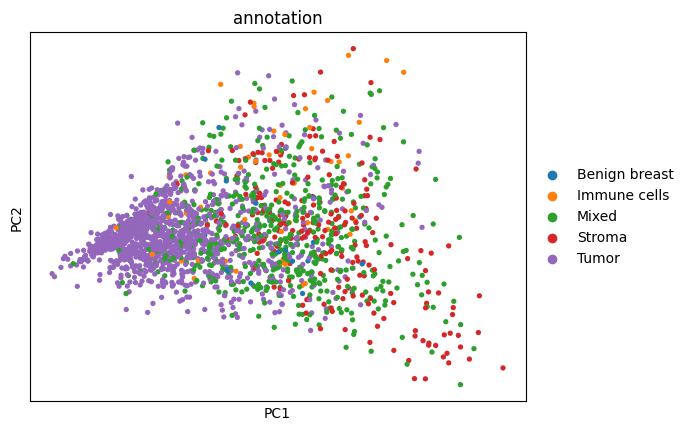

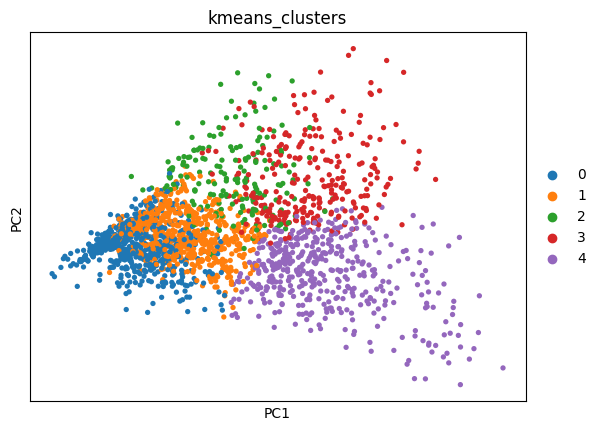

Adjusted Rand Index (ARI): 0.16968858239531268


In [9]:
PCA_clustering(adata_T)

2024-07-31 14:28:44.871614: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


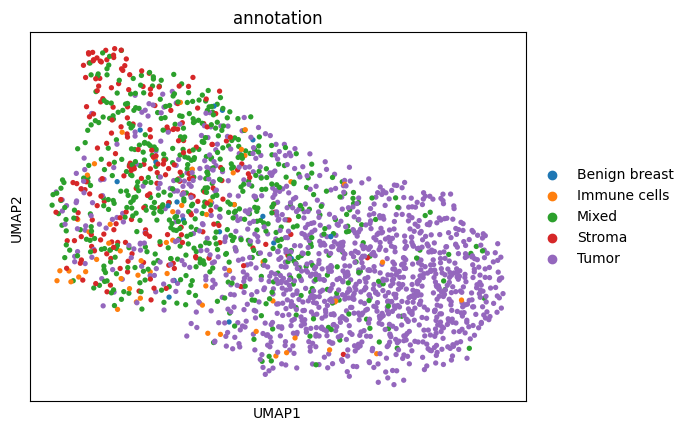

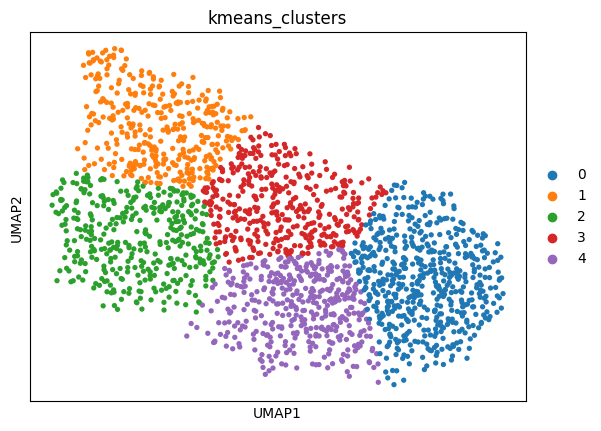

Adjusted Rand Index (ARI): 0.15918152540196642


In [10]:
UMAP_clustering(adata_T)

# For segmentation data

## With Stardist

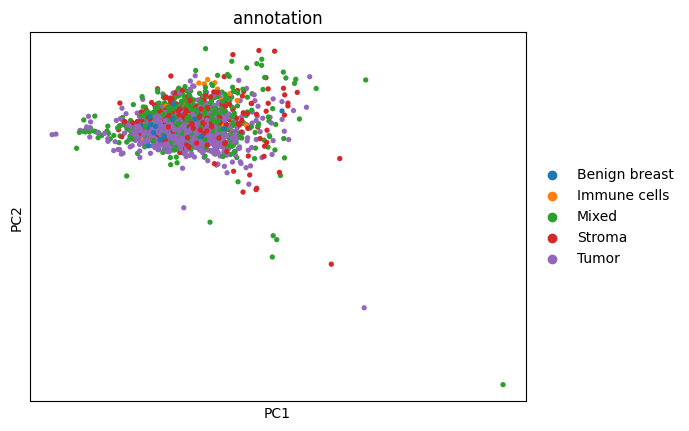

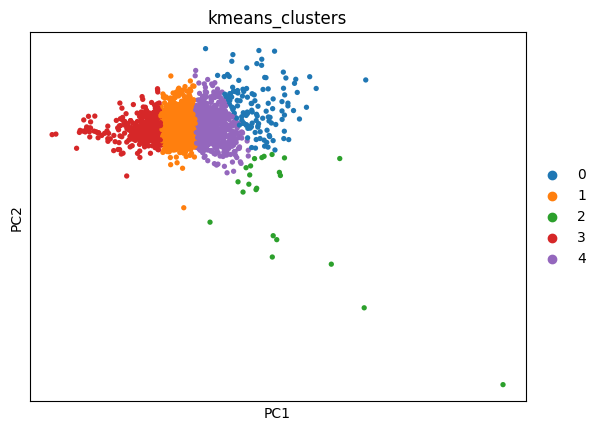

Adjusted Rand Index (ARI): 0.02496178779258671


In [11]:
PCA_clustering(adata_S)

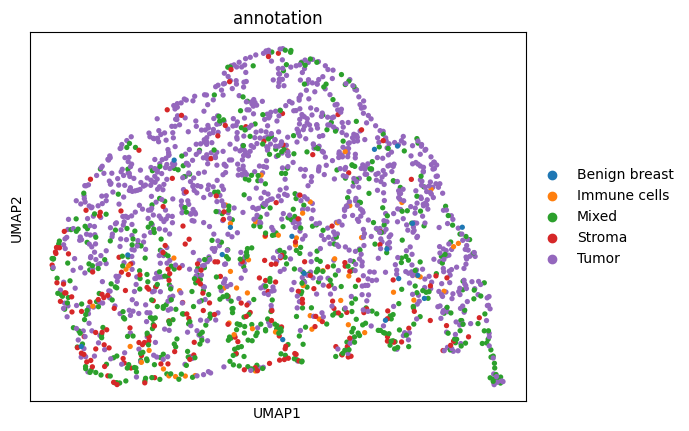

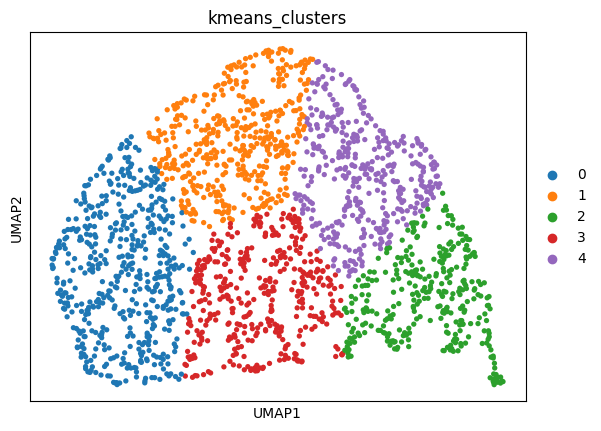

Adjusted Rand Index (ARI): 0.03503510466346318


In [12]:
UMAP_clustering(adata_S)

## With Kimianet

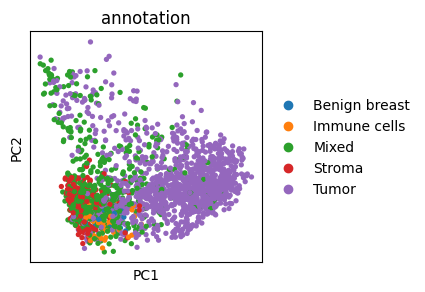

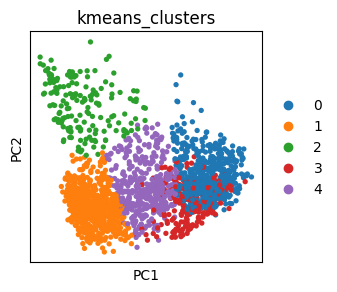

Adjusted Rand Index (ARI): 0.14822307728322223


In [33]:
PCA_clustering(adata_K)

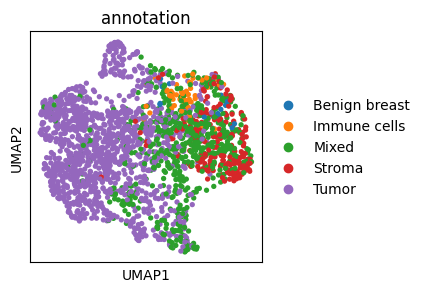

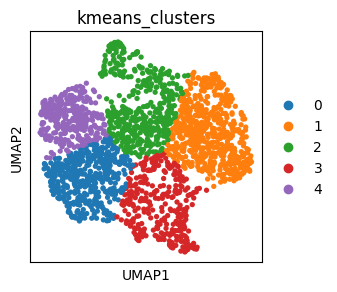

Adjusted Rand Index (ARI): 0.13891280368448183


In [34]:
UMAP_clustering(adata_K)

# Plot on the slide

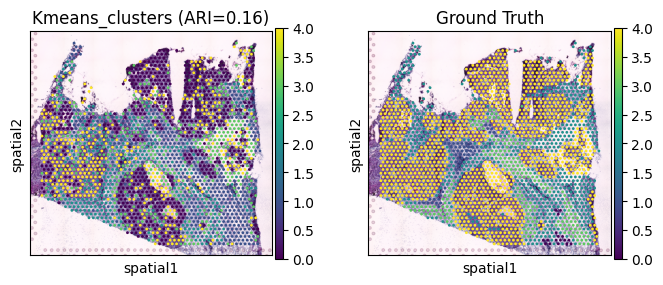

In [26]:
plot_on_slide(adata_T)

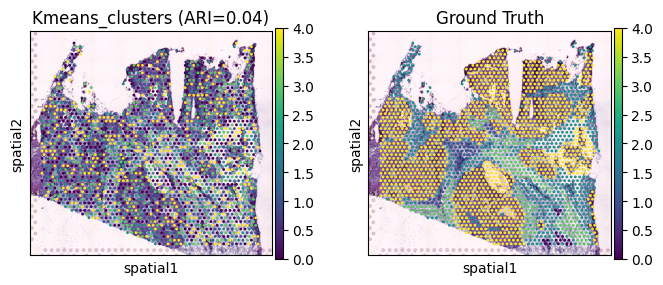

In [25]:
plot_on_slide(adata_S)

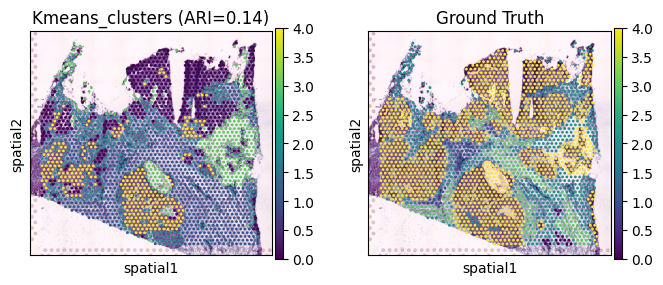

In [35]:
plot_on_slide(adata_K)